# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [61]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.datasets import make_classification
sns.set(style="darkgrid")
print("install end")

install end


In [4]:
print("Hello world!")

Hello world!


## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

##### найдем производную сигмоидной функции

#### $$\frac{d\sigma}{dz} = \sigma(z)(1 - \sigma(z))
$$

#### Сразу реализуем сигмоидную функцию активации 
$$ \frac{1}{e^{-value} + 1}$$


In [134]:
def sigmoid(value):
    return 1 / (1 + np.exp(-value))

#### Тогда градиент логистической части функции потерь по весу w_j для j-го признака будет:
$$\frac{\partial L}{\partial w_j} = \sum_{i=1}^{N} (y_i - \sigma(w^T x_i))x_{ij}$$
#### Градиент регуляризационной части L1(Lasso) по весу w_j
$$\frac{\partial}{\partial w_j} \gamma \|w\|_1 = \gamma \cdot \text{sign}(w_j)
$$
#### Градиент регуляризационной части L2(Ridge) по весу w_j
$$\frac{\partial}{\partial w_j} \beta \|w\|^2_2 = 2 \cdot \beta \cdot w_j
$$
#### Объединяем:
$$\nabla_w L(w) = \sum_{i=1}^{N} (y_i - \sigma(w^T x_i))x_{i} + \gamma \cdot \text{sign}(w) + 2 \cdot \beta \cdot w
$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [192]:
#def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
def loss(X, y, w:List[float], gamma=1.0, beta=1.0):
    w = np.array(w)
    
    predictions = sigmoid(np.dot(X, w))
    
    log_loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
    
    l1_penalty = gamma * np.sum(np.abs(w))
    
    l2_penalty = beta * np.sum(w ** 2)
    
    total_loss = log_loss + l1_penalty + l2_penalty
    return total_loss


#### 3. [0.25 points] Implement the gradient (as a function)

### Возвращаемся к пункту 1:
$$\nabla_w L(w) = \sum_{i=1}^{N} (y_i - \sigma(w^T x_i))x_{i} + \gamma \cdot \text{sign}(w) + 2 \cdot \beta \cdot w
$$

In [85]:
#def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
#    grad_w = #...

#    return grad_w

def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    sigma = sigmoid(np.dot(X, w))
    grad_result = np.dot(X.T, (sigma - y)) + gamma * np.sign(w) + 2 * beta * w
    
    return grad_result

#### Check yourself

In [86]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)
print("Hi PAul!")

Hi PAul!


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [101]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [265]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42, threshold=0.65):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.threshold = threshold # added a parameter for comparison
        self.random_state = random_state
        self.w = None
        self.loss_history = None
        self.threshold = threshold
        # you may additional properties if you wish

    def fit(self, X, y):
        # Ensure input features include the bias term
        X_with_bias = np.column_stack((np.ones(X.shape[0]), X))
    
        # Initialize model parameters if they haven't been already
        self.w = self.w or np.random.normal(scale=0.1, size=X_with_bias.shape[1])
    
        self.loss_history = []
        iteration = 0
        converged = False
    
        # convergence check
        while iteration < self.max_iter and not converged:
            current_w = self.w.copy()
        
            # Calculate gradient and update weights
            grad = self.compute_gradient(X_with_bias, y)
            self.w -= self.learning_rate * grad
        
            # Record loss for the current iteration
            current_loss = self.compute_loss(X_with_bias, y)
            self.loss_history.append(current_loss)
        
            iteration += 1
            # Check convergence
            converged = np.linalg.norm(self.w - current_w) <= self.tolerance

        return self

    def predict(self, X):
        # Make sure the model has been trained before making predictions
        if self.w is None:
            raise ValueError("The model must be trained before making predictions.")
        
        X = np.c_[np.ones(X.shape[0]), X]

        # Compute the probabilities using the sigmoid function
        probabilities = sigmoid(np.dot(X, self.w))

        # Assign class labels based on the probability threshold
        predictions = (probabilities >= self.threshold).astype(int)

        return predictions
    
    def compute_gradient(self, X, y):
        l1 = np.dot(self.gamma, np.sign(self.w))
        l2 = np.dot(2*self.beta, self.w)
        # y_pred = self._predict(X)
        y_pred = sigmoid(np.dot(X, self.w))
        return np.add(l1, np.add(l2, np.dot(np.transpose(X), np.subtract(y_pred, y))))

    def compute_loss(self, X, y):
        y_pred = sigmoid(np.dot(X, self.w))
        temp = np.dot(1 - y, np.log(1 - y_pred))
        trash = np.sum(np.dot(y, np.log(y_pred)))
        # l1 + l2 - ...
        return self.gamma*np.sum(np.abs(self.w)) + self.beta*np.sum(np.square(self.w)) - trash + temp
    
    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        return np.array([1 / (np.exp(np.dot(X, self.w)) + 1),\
                         1 / (np.exp(-np.dot(X, self.w)) + 1)])

In [275]:
# sample data to test your model
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

print("computed!")

computed!


In [276]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)
    

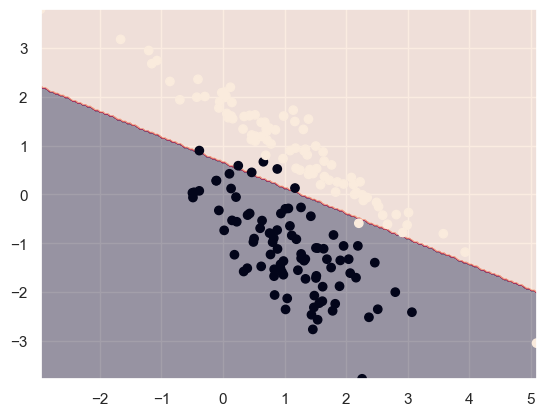

In [277]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

### Я сранивал бинарную классификацию на разных порогах [0.5;1] и самые лучшие показатели на мой взгляд дал threshold = 0.65

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

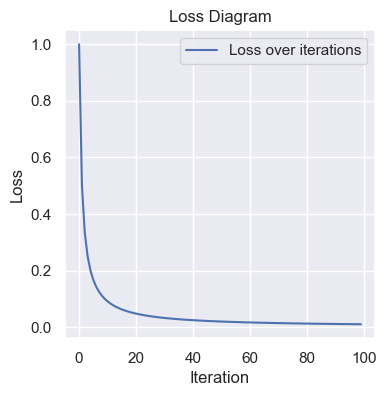

In [278]:
def plot_loss_diagram(loss_history):
    plt.figure(figsize=(4, 4))
    plt.plot(loss_history, label='Loss over iterations')
    plt.title('Loss Diagram')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



plot_loss_diagram(mock_loss_history)

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [ ]:
# your code here

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [ ]:
# your code here

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [ ]:
# your code here

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [ ]:
# your code here